In [1]:
import torch.nn as nn
import torch
import numpy as np
from tqdm import trange
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import create_feature_extractor

def get_feature_func(model, layer='layer0'):
    # create feature extractor for particular layer
    layer_node_map = {
        'layer0': 'bn1',
        'layer1':'layer1.0.bn1', 
        'layer2':'layer2.0.bn1', 
        'layer3':'layer3.0.bn1', 
        'layer4':'layer4.0.bn1', 
        'fc': 'fc',
    }

    return_node = {layer_node_map[layer]: layer}
    feat_ext = create_feature_extractor(model, return_nodes=return_node)
    return feat_ext

def get_feature_vis(model, lr=0.1, transform=None, layer='layer0', channel_id=0, image_size=64, device=torch.device('cpu'), optim_steps=[1, 32, 128, 256, 2048], momentum=0.5, sigma_range=(1, 2), blur=False, l1_weight=0.1):
    # get feat ext
    model = get_feature_func(model, layer)

    # turn off grads for model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # init random image with true grad
    model.img = nn.Parameter(torch.clamp(torch.randn((1,3, image_size, image_size), requires_grad = True, device=device), -2, 2))
    optim = torch.optim.SGD([model.img], lr=lr, momentum=momentum) # lr =1e-1 #

    # iterate and optimize image
    images = []

    for i in trange(np.max(optim_steps)):
        img = model.img
        if transform is not None:
            img = img.to(torch.device('cpu')) # move to cpu because some transforms not implemented on mps
            img = transform(img)
            img = img.to(device)
            
        loss = -torch.mean(model(img)[layer][:,channel_id]) + l1_weight * torch.mean(torch.linalg.matrix_norm(img, ord=1))
        loss.backward() # backward pass
        optim.step() # gradient descent

        with torch.no_grad():
            if blur:
                sigma = sigma_range[0] + ((sigma_range[1] - sigma_range[0]) * i) / np.max(optim_steps)
                blur_trans = transforms.GaussianBlur(21, sigma=sigma)
                model.img.data = blur_trans(model.img)

            model.img.data = torch.clamp(model.img, -2, 2)

        if i+1 in optim_steps:
            # save the image
            mei = torch.clamp(model.img[0, :, :, :] * 0.225 + 0.45, 0, 1)
            images.append(mei.permute(1, 2, 0).detach().cpu().numpy())

    return images

In [2]:
import torch
from torchvision.transforms import RandomRotation, RandomCrop
from torchvision.transforms.v2 import GaussianNoise
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device('mps')
image_size = 232

model = resnet50(weights=ResNet50_Weights.DEFAULT) 
model.to(device)   
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
import matplotlib.pyplot as plt

def display_images(images, steps, im_pad):
    fig,axs = plt.subplots(1, 5, figsize=(12, 3))
    for idx, image in enumerate(images):
        plt.sca(axs[idx])
        plt.imshow(image[im_pad:-im_pad, im_pad:-im_pad], interpolation=None)
        plt.title(f'step {steps[idx]}')
        plt.axis('off')
    plt.show()

100%|██████████| 2048/2048 [00:01<00:00, 1036.64it/s]


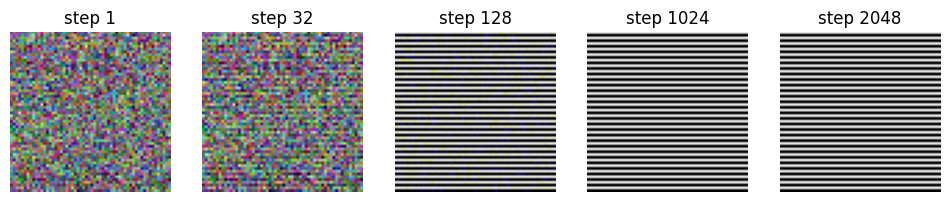

100%|██████████| 2048/2048 [00:01<00:00, 1415.86it/s]


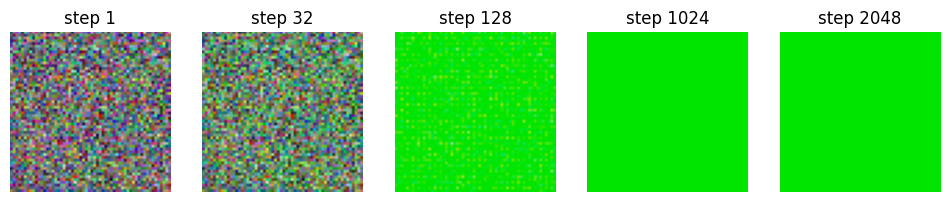

100%|██████████| 2048/2048 [00:02<00:00, 735.59it/s]


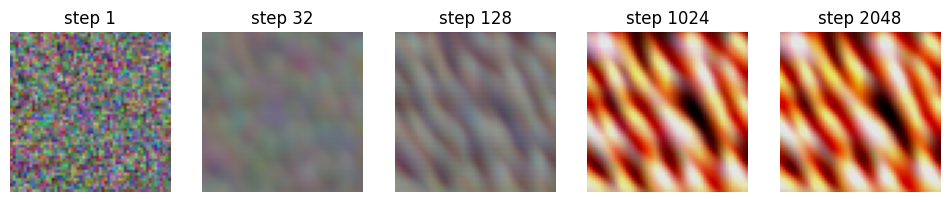

100%|██████████| 2048/2048 [00:02<00:00, 740.68it/s]


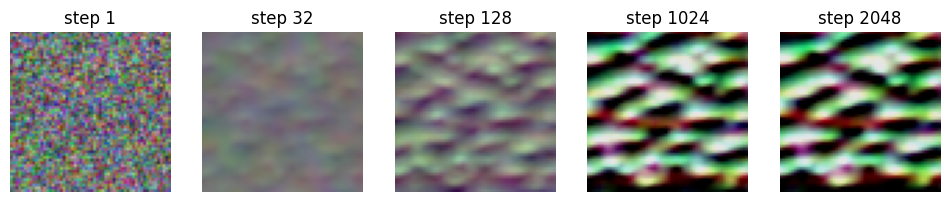

100%|██████████| 2048/2048 [00:34<00:00, 58.52it/s]


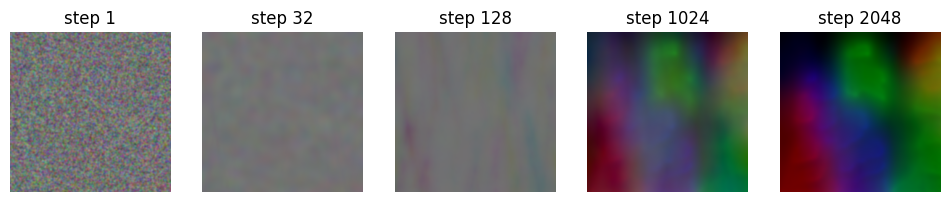

100%|██████████| 2048/2048 [00:35<00:00, 58.00it/s]


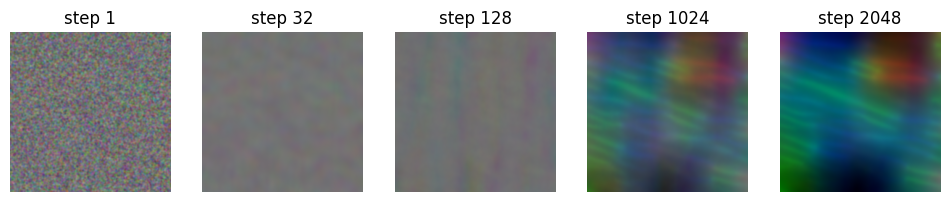

100%|██████████| 2048/2048 [00:38<00:00, 53.17it/s]


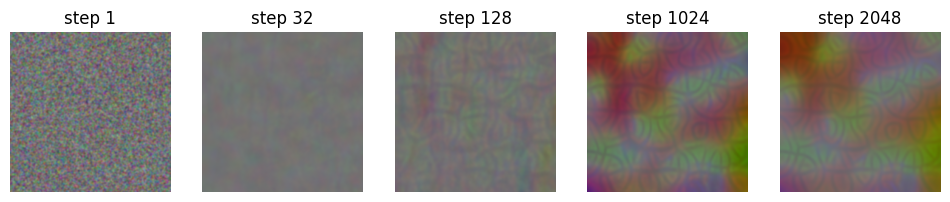

100%|██████████| 2048/2048 [00:36<00:00, 55.57it/s]


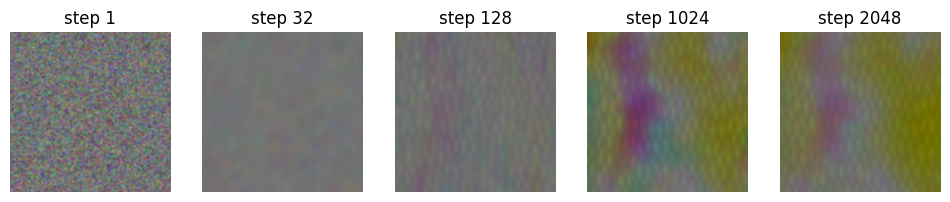

100%|██████████| 2048/2048 [00:47<00:00, 43.06it/s]


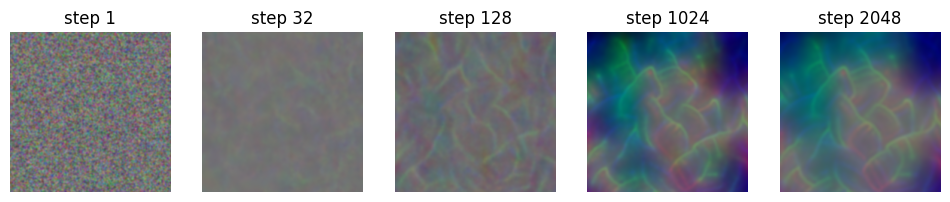

100%|██████████| 2048/2048 [00:44<00:00, 45.74it/s]


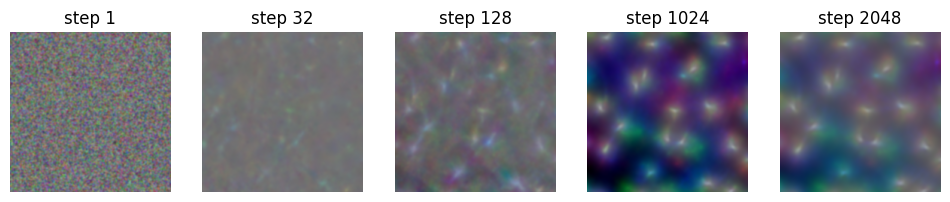

100%|██████████| 2048/2048 [01:00<00:00, 34.05it/s]


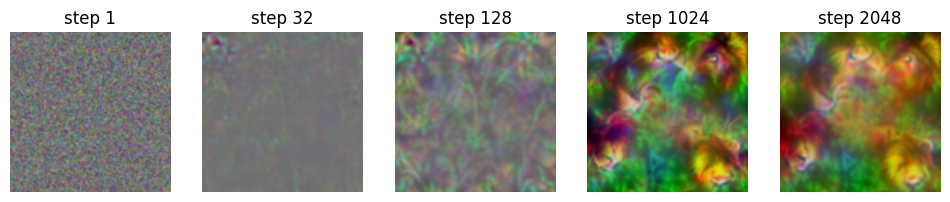

100%|██████████| 2048/2048 [00:56<00:00, 35.94it/s]


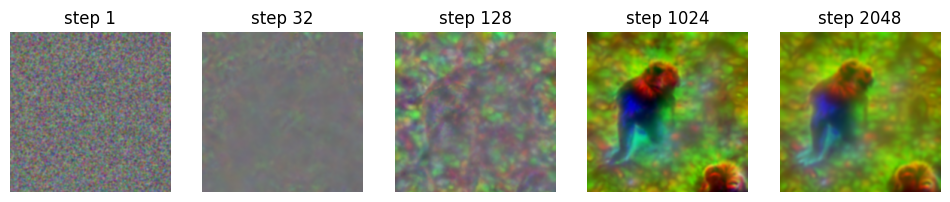

In [4]:
transform = transforms.Compose([
    RandomCrop(200, 200),
    RandomRotation(15),
    GaussianNoise(), 
])

steps = [1, 32, 128, 1024, 2048]

# parameters for each layer 
lay_names = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
sigma_ranges = [(0.5, 1), (0.5, 1), (1, 1.5), (1, 2), (1, 2), (1, 2)]
l1_weights = [0, 0, 0.1, 0.1, 0.1, 0]
image_sizes = [64, 64, 232, 232, 232, 232]
blurs = [False, True, True, True, True, True]
ts = [None, None, transform, transform, transform, transform]
momentums = [0, 0, 0.5, 0.6, 0.6, 0.6]
lrs = [0.5, 0.5, 0.25, 0.25, 0.25, 0.25]
lay_pads = [3, 3, 5, 7, 9, 9]
channel_ids = [[1, 11], [1, 2], [1, 3], [0, 1], [0, 1], [291, 373]]

all_images = []
for lay_id in range(len(lay_names)):
    ims = []
    for iii in channel_ids[lay_id]:
        images = get_feature_vis(model, lr=lrs[lay_id], momentum=momentums[lay_id], transform=ts[lay_id], image_size=image_sizes[lay_id], device=device, layer=lay_names[lay_id], channel_id=iii, optim_steps=steps, blur=blurs[lay_id], sigma_range=sigma_ranges[lay_id], l1_weight=l1_weights[lay_id])
        display_images(images, steps, im_pad=lay_pads[lay_id])
        ims.append(images[-1])
    all_images.append(ims)

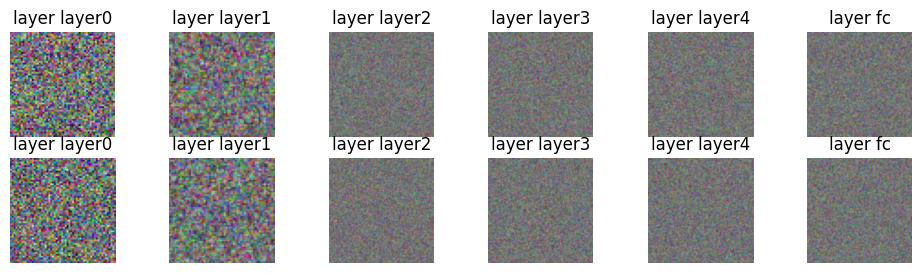

In [15]:
fig, axs = plt.subplots(2, len(lay_names), figsize=(12, 3))

for lay_id in range(len(lay_names)):
    for idx, iii in enumerate(channel_ids[lay_id]):
        plt.sca(axs[idx, lay_id])
        im_pad=lay_pads[lay_id]
        plt.imshow(all_images[lay_id][idx][im_pad:-im_pad, im_pad:-im_pad], interpolation=None)
        plt.title(f'layer {lay_names[lay_id]}')
        plt.axis('off')

In [14]:
(all_images[lay_id][idx]).shape

(232, 232, 3)